# Análisis de series temporales mediante RNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

2025-05-06 18:25:19.121984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configuración para limitar el uso de memoria (especialmente útil en máquinas con recursos limitados)

In [2]:
# No tengo GPU en mi portátil

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Generación datos sintéticos

In [4]:
total_muestras = 50000

In [5]:
# Cargar datos de ejemplo (temperatura diaria)
# Usaremos datos sintéticos para este ejemplo
np.random.seed(42)
dates = pd.date_range(start="2020-01-01", periods=total_muestras)
temp_base = 20 + 15 * np.sin(np.linspace(0, 4*np.pi, total_muestras))  # Ciclo anual
weekly = 3 * np.sin(np.linspace(0, 52*np.pi, total_muestras))          # Ciclo semanal
noise = np.random.normal(0, 2, total_muestras)                         # Ruido aleatorio
temperature = temp_base + weekly + noise

df = pd.DataFrame({'Date': dates, 'Temperature': temperature})
df.set_index('Date', inplace=True)

## Visualizamos datos sintéticos

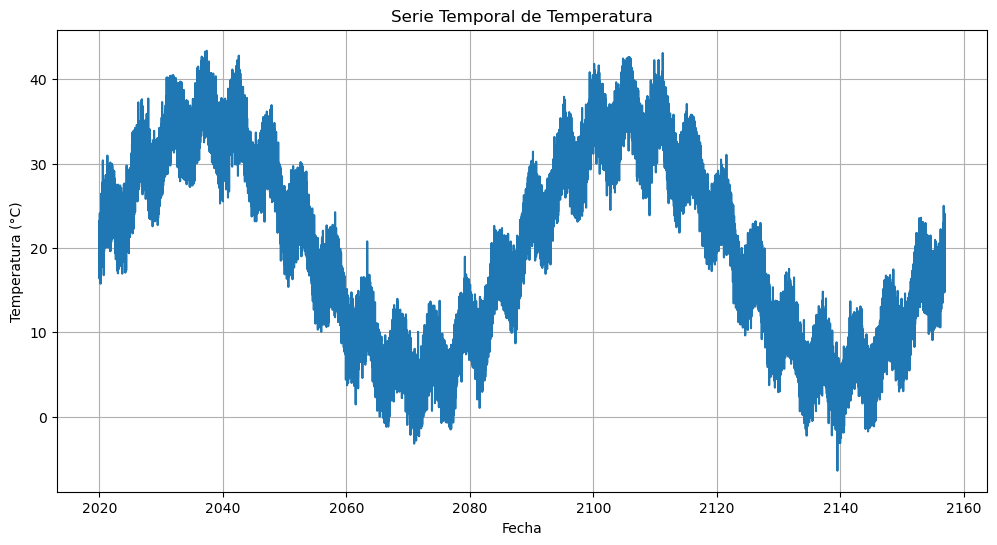

In [6]:
# Visualizar los datos
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Temperature'])
plt.title('Serie Temporal de Temperatura')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.show()

# Procesamiento de los datos

In [7]:
data = df.values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Creador de secuencias

In [8]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

## Creamos secuencias

In [9]:
sequence_length = 100 
X, y = create_sequences(scaled_data, sequence_length)

In [10]:
X.shape

(49900, 100, 1)

# Dividimos en entrenamiento y test

In [11]:
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Creación del modelo

In [12]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo

In [14]:
# Configuramos early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [15]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

Epoch 1/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 72s 60ms/step - loss: 0.0181 - val_loss: 0.0017
Epoch 2/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 61s 54ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 3/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 4/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 5/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 6/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 7/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 8/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 9/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 11/200
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - loss: 0.0028 - val_loss: 0.00

# Visualizamos el entrenamiento

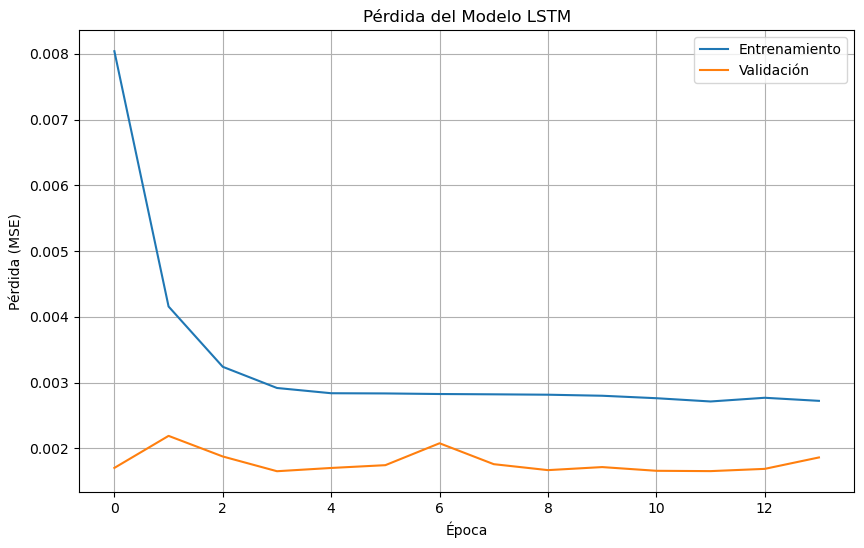

In [16]:
# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo LSTM')
plt.ylabel('Pérdida (MSE)')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.show()

# Realizamos predicciones

In [17]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

1248/1248 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


## Invertimos las normalizaciones de las predicciones

In [18]:
train_predictions = scaler.inverse_transform(train_predictions)
y_train_inv = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test_inv = scaler.inverse_transform(y_test)

# Calculamos los errores

In [19]:
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predictions))
print(f'RMSE Entrenamiento: {train_rmse:.3f}')
print(f'RMSE Prueba: {test_rmse:.3f}')

RMSE Entrenamiento: 2.060
RMSE Prueba: 2.068


# Visualización de resultados

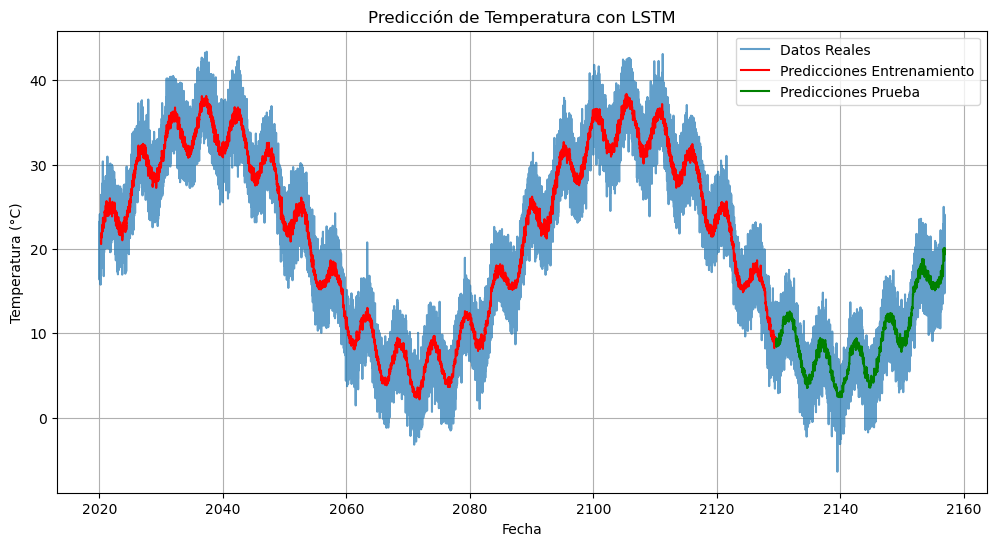

In [20]:
train_pred_dates = df.index[sequence_length:sequence_length+len(train_predictions)]
test_pred_dates = df.index[sequence_length+len(train_predictions):sequence_length+len(train_predictions)+len(test_predictions)]

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Temperature'], label='Datos Reales', alpha=0.7)
plt.plot(train_pred_dates, train_predictions, label='Predicciones Entrenamiento', color='red')
plt.plot(test_pred_dates, test_predictions, label='Predicciones Prueba', color='green')
plt.title('Predicción de Temperatura con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Predicción a futuro

In [21]:
future_steps = 30
last_sequence = scaled_data[-sequence_length:]
future_predictions = []

In [22]:
for _ in range(future_steps):
    # Obtener la secuencia actual (reshape para el modelo)
    current_seq = last_sequence.reshape(1, sequence_length, 1)
    # Predecir el siguiente valor
    next_pred = model.predict(current_seq)
    # Añadir la predicción a nuestra lista
    future_predictions.append(next_pred[0, 0])
    # Actualizar la secuencia para la siguiente predicción
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

## Invertimos la escala de las predicciones

In [23]:
# Convertir las predicciones futuras a la escala original
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

## Creamos las fechas de las predicciones

In [24]:
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps)

## Visualizamos los resultados

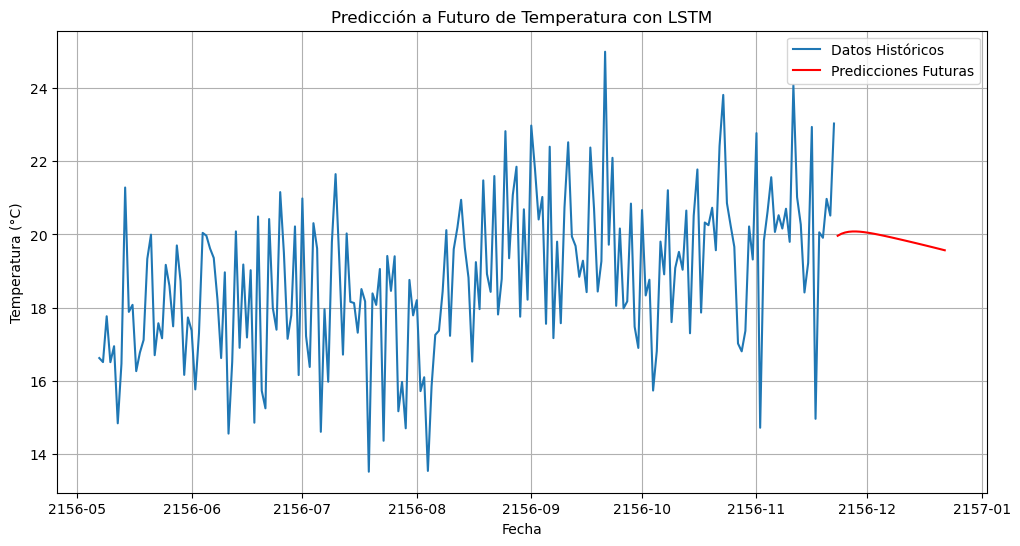

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-200:], df['Temperature'].iloc[-200:], label='Datos Históricos')
plt.plot(future_dates, future_predictions, label='Predicciones Futuras', color='red')
plt.title('Predicción a Futuro de Temperatura con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()